# 1. Setup

## 1.1. Install Dependencies

In [1]:
# Install tensorflow link for reference: https://www.tensorflow.org/install/pip

# Create the virtual environment
# conda create --name Name python=3.9

# Activate the virtual environment
# conda activate Name

# Install CUDA and cuDNN
# conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# pip install --upgrade pip

# Install packages from requirements.txt
# pip install -r requirements.txt

# Check for GPU devices
# python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

## 1.2. Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input
import tensorflow as tf

## 1.3. Set GPU Growth

In [4]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import tensorflow as tf

# Initialize a session to list devices
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

# Filter out GPU devices and print them
gpus = [device for device in devices if device.device_type == 'GPU']
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs available.")

GPUs available:
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5729419264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17067686396336157295
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:10:00.0, compute capability: 8.6"
xla_global_id: 416903419



In [6]:
# Avoid Out Of Memory (OOM) errors by setting GPU Memory Consumption Growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
len(gpus)

1

In [8]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.4. Create Folder Structure

In [9]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
POS_PATH

'data\\positive'

In [11]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Positives and Anchors

## 2.1. Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw
# Access website above to download `All images as gzipped tar file`
# Place file `lfw.tgz` in the working directory

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [12]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2. Collecte Positive and Anchor Classes

In [13]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
# Establish a connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250 x 250 px
    frame = frame[120:120+250, 200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release webcam
cap.release()
# Close image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

# 3. Load and Preprocess Images

## 3.1. Get Image Directories

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [15]:
dir_test = anchor.as_numpy_iterator()

In [16]:
dir_test.next()

b'data\\anchor\\d07cfd56-1c6c-11ef-836a-845cf3d6a57d.jpg'

## 3.2.Preprocessing - Scale and Resize

In [17]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    return img

In [18]:
preprocess('data\\anchor\\d04f55a0-1c6c-11ef-95b1-845cf3d6a57d.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.7414216 , 0.7610294 , 0.74534315],
        [0.7372549 , 0.75686276, 0.7411765 ],
        [0.7355392 , 0.75514704, 0.73946077],
        ...,
        [0.6894608 , 0.69730395, 0.6855392 ],
        [0.68235296, 0.6901961 , 0.6784314 ],
        [0.67156863, 0.67941177, 0.6598039 ]],

       [[0.7372549 , 0.7558824 , 0.74313724],
        [0.73333335, 0.7522059 , 0.7387255 ],
        [0.7355392 , 0.75514704, 0.73946077],
        ...,
        [0.68602943, 0.6938726 , 0.68210787],
        [0.68235296, 0.6901961 , 0.6784314 ],
        [0.672549  , 0.68039215, 0.66862744]],

       [[0.7372549 , 0.7529412 , 0.7490196 ],
        [0.73259807, 0.74852943, 0.7438725 ],
        [0.73039216, 0.7492647 , 0.7357843 ],
        ...,
        [0.68235296, 0.6901961 , 0.6784314 ],
        [0.68235296, 0.6901961 , 0.6784314 ],
        [0.6784314 , 0.6862745 , 0.68039215]],

       ...,

       [[0.31862745, 0.30686274, 0.3735294 ],
        [0.32

In [19]:
img = preprocess('data\\anchor\\d04f55a0-1c6c-11ef-95b1-845cf3d6a57d.jpg')

In [20]:
img.numpy().max()

0.8068628

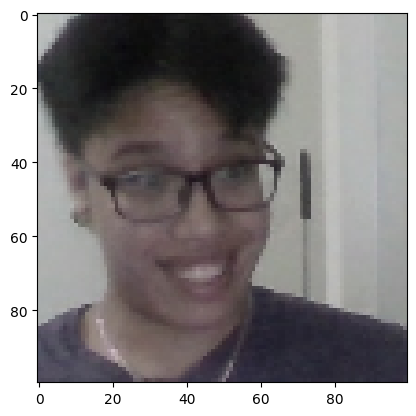

In [21]:
plt.imshow(img)

## 3.3. Create Labelled Dataset

In [22]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [23]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [26]:
samples = data.as_numpy_iterator()

In [27]:
samples.next()

(b'data\\anchor\\d4e91d65-1c6c-11ef-912b-845cf3d6a57d.jpg',
 b'data\\positive\\21aba677-1c6d-11ef-af77-845cf3d6a57d.jpg',
 1.0)

## 3.4. Build Train and Test Set

In [28]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [29]:
example = samples.next()

In [30]:
example

(b'data\\anchor\\ced6a48a-1c6c-11ef-8994-845cf3d6a57d.jpg',
 b'data\\positive\\fcf560a6-1c6c-11ef-8988-845cf3d6a57d.jpg',
 1.0)

In [31]:
res = preprocess_twin(*example)

In [32]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.7411765 , 0.7490196 , 0.74509805],
         [0.7411765 , 0.7490196 , 0.74313724],
         [0.7411765 , 0.7490196 , 0.7372549 ],
         ...,
         [0.6764706 , 0.6901961 , 0.6877451 ],
         [0.68235296, 0.6901961 , 0.6862745 ],
         [0.6784314 , 0.6862745 , 0.6745098 ]],
 
        [[0.74583334, 0.7526961 , 0.75171566],
         [0.7441176 , 0.7519608 , 0.7480392 ],
         [0.74485296, 0.7526961 , 0.7443628 ],
         ...,
         [0.6742647 , 0.6938726 , 0.6762255 ],
         [0.67941177, 0.6901961 , 0.6754902 ],
         [0.68235296, 0.6901961 , 0.67058825]],
 
        [[0.74215686, 0.74607843, 0.75392157],
         [0.7372549 , 0.74289215, 0.74558824],
         [0.74019605, 0.7480392 , 0.7441176 ],
         ...,
         [0.6742647 , 0.6938726 , 0.67034316],
         [0.6720588 , 0.6894608 , 0.6666667 ],
         [0.6754902 , 0.68333334, 0.6637255 ]],
 
        ...,
 
        [[0.31887254, 0.30318627

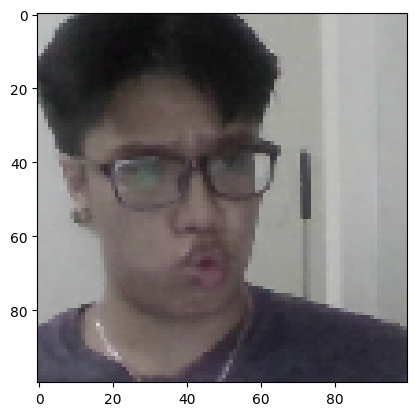

In [33]:
plt.imshow(res[0])

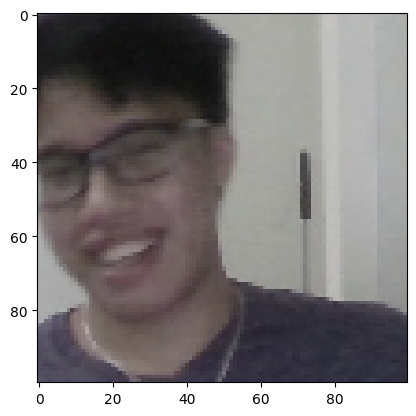

In [34]:
plt.imshow(res[1])

In [35]:
res[2]

1.0

In [36]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [37]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [38]:
samples = data.as_numpy_iterator()

In [39]:
sample = samples.next()

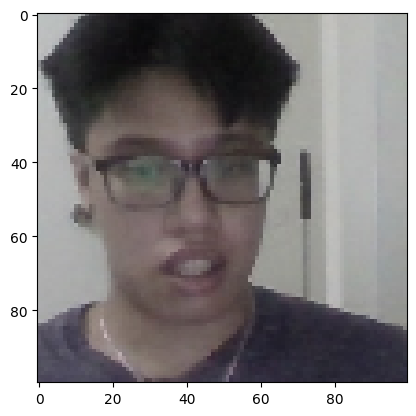

In [40]:
plt.imshow(sample[0])

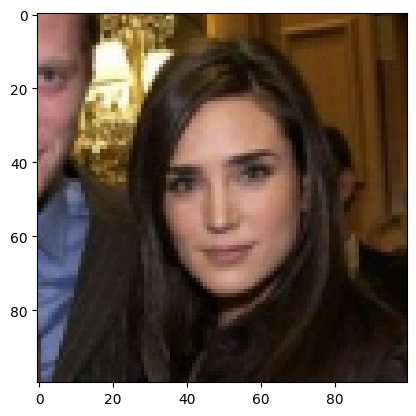

In [41]:
plt.imshow(sample[1])

In [42]:
sample[2]

0.0

In [43]:
# Training set
train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [44]:
# Testing set
test_data = data.skip(round(len(data) * .7))
test_data = test_data.take(round(len(data) * .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1. Build Embedding Layer

In [45]:
inp = Input(shape=(100,100,3), name='input_image')

In [46]:
inp # None refer to batch size

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [47]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [48]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [49]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [50]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [51]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [52]:
6*6*256

9216

In [53]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [54]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [55]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [56]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [57]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [58]:
embedding = make_embedding()

In [59]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2. Build Distance Layer

In [60]:
# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3. Make Siamese Model

In [61]:
input_image = Input(name='input_image', shape=(100,100,3))
validation_image = Input(name='va;idation_image', shape=(100,100,3))

In [62]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [63]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [64]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [65]:
siamese_layer = L1Dist()

In [66]:
siamese_layer(inp_embedding, val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist')>

In [67]:
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

In [68]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [69]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [70]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 va;idation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'va;idation_image[0

In [71]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_image', shape=(100,100,3))
    
    # Validation image in the network
    validation_image = Input(name='va;idation_image', shape=(100,100,3))
    
    # Combine Siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [72]:
siamese_model = make_siamese_model()

In [73]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 va;idation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'va;idation_image[0

#  5. Training

## 5.1. Setup Loss and Optimizer

In [74]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [75]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2. Establish Checkpoints

In [76]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3. Build Train Step Function

In [77]:
test_batch = train_data.as_numpy_iterator()

In [78]:
batch_1 = test_batch.next()

In [79]:
batch_1[0]

array([[[[0.73284316, 0.7563726 , 0.74852943],
         [0.7318627 , 0.74460787, 0.7436274 ],
         [0.7345588 , 0.7384804 , 0.7522059 ],
         ...,
         [0.6784314 , 0.6862745 , 0.6745098 ],
         [0.6852941 , 0.6931372 , 0.6813725 ],
         [0.6791667 , 0.6870098 , 0.6752451 ]],

        [[0.70612746, 0.72769606, 0.72083336],
         [0.6102941 , 0.6230392 , 0.6220588 ],
         [0.45882353, 0.4627451 , 0.4764706 ],
         ...,
         [0.6745098 , 0.69411767, 0.6784314 ],
         [0.6754902 , 0.69509804, 0.67941177],
         [0.6666667 , 0.6862745 , 0.67058825]],

        [[0.4272059 , 0.44877452, 0.44191176],
         [0.36740196, 0.38014707, 0.38504902],
         [0.35637254, 0.3602941 , 0.3754902 ],
         ...,
         [0.6767157 , 0.6875    , 0.6791667 ],
         [0.68259805, 0.6933824 , 0.68063724],
         [0.6764706 , 0.6872549 , 0.6745098 ]],

        ...,

        [[0.29313725, 0.2882353 , 0.34313726],
         [0.30784315, 0.2990196 , 0.35686275]

In [80]:
X = batch_1[:2]

In [81]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [82]:
y = batch_1[2]

In [83]:
y

array([0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

In [84]:
@tf.function
def train_step(batch):
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    print(loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
        
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4. Build Training Loop

In [85]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\nEpoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
    
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx + 1)
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5. Train the model

In [86]:
EPOCHS = 50

In [87]:
train(train_data, EPOCHS)


Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 17s 209ms/step

Epoch 2/50
27/27 [==============================] - 5s 198ms/step

Epoch 3/50
27/27 [==============================] - 5s 194ms/step

Epoch 4/50
27/27 [==============================] - 5s 194ms/step

Epoch 5/50
27/27 [==============================] - 5s 190ms/step

Epoch 6/50
27/27 [==============================] - 5s 189ms/step

Epoch 7/50
27/27 [==============================] - 5s 185ms/step

Epoch 8/50
27/27 [==============================] - 5s 183ms/step

Epoch 9/50
27/27 [==============================] - 5s 180ms/step

Epoch 10/50
27/27 [==============================] - 5s 180ms/step

Epoch 11/50
27/27 [==============================] - 5s 185ms/step

Epoch 12/50
27/27 [==============================] - 5s 180ms/step

Epoch 13/50
27/27 [==================

# 6. Evaluate Model

## 6.1. Import Metrics

In [88]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2. Make predictions

In [89]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [90]:
test_var = test_data.as_numpy_iterator().next()

In [91]:
test_var[2]

array([0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

In [92]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 96ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [4.3060636e-06],
       [1.1078893e-08],
       [2.3133016e-09],
       [9.9999273e-01],
       [1.0000000e+00],
       [9.9999952e-01],
       [1.8508237e-08],
       [2.3478620e-07],
       [9.9151039e-01],
       [1.0000000e+00],
       [9.9999833e-01],
       [1.5093276e-09],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [93]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]

In [94]:
y_true

array([1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

## 6.3. Calculate Metrics

In [95]:
# Create a metric object
m = Recall()

# Calculate recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [96]:
# Create a metric object
m = Precision()

# Calculate precision value
m.update_state(y_true, y_hat)

# Return Precision Result
m.result().numpy()

1.0

## 6.4. Visualize Results

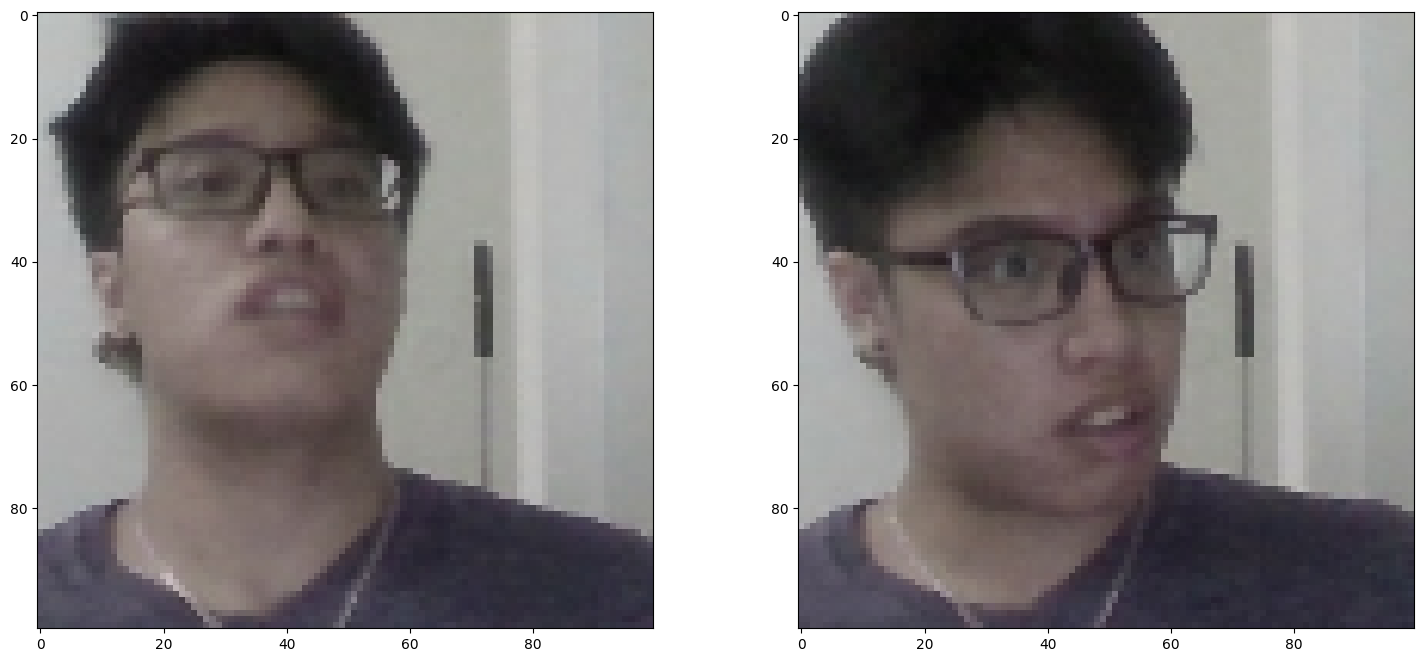

In [97]:
# Set plot size
plt.figure(figsize=(18,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Render cleanly
plt.show()

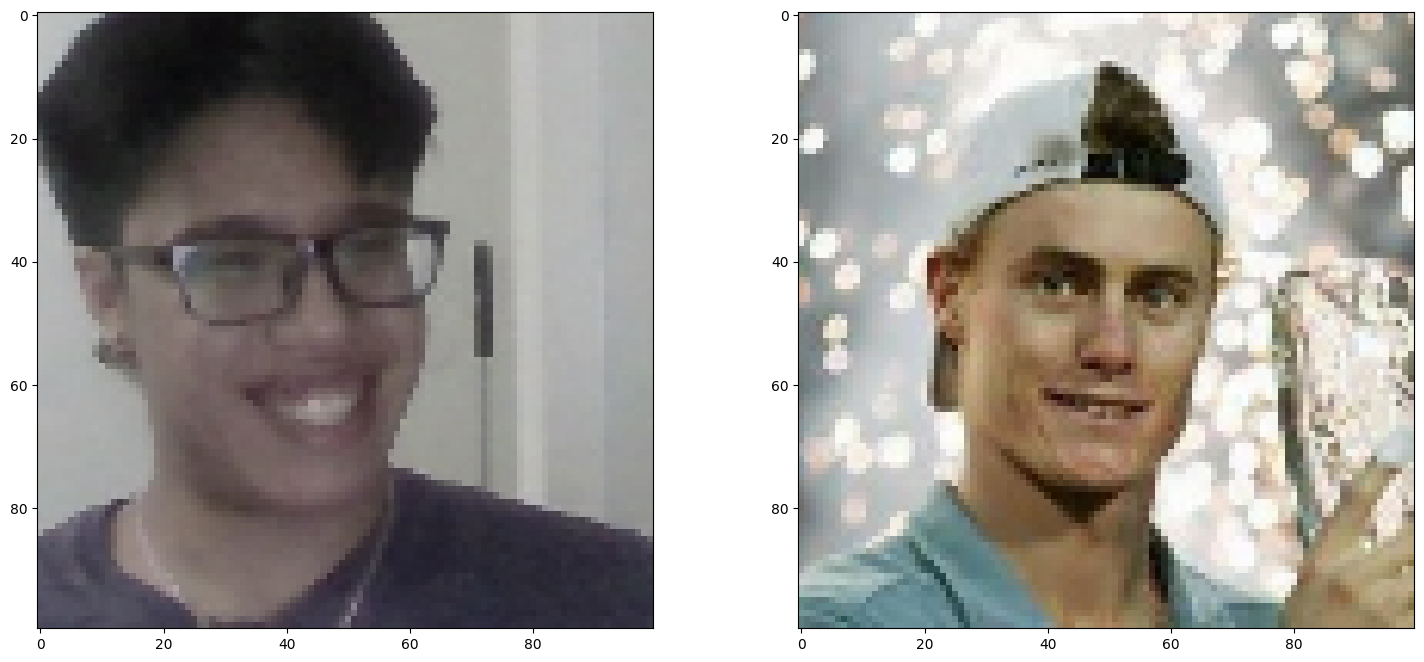

In [98]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.show()

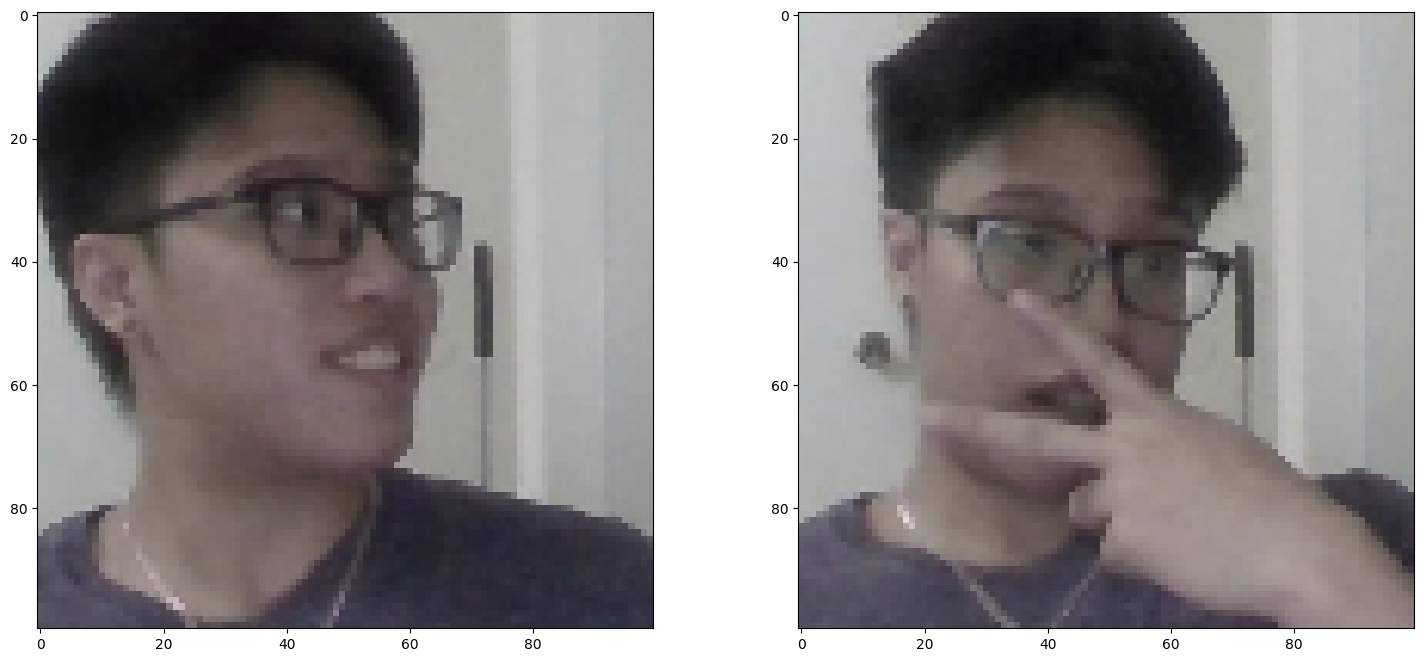

In [99]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

# 7. Save Model

In [100]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [101]:
# Reload model
reloaded_model = tf.keras.models.load_model('siamesemodel.h5',
                                           custom_objects={
                                               'L1Dist': L1Dist,
                                               'BinaryCrossentropy': tf.losses.BinaryCrossentropy
                                           })

In [102]:
# Make predictions with reloaded model
reloaded_model.predict([test_input, test_val])

1/1 [==============================] - 0s 75ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [4.3060636e-06],
       [1.1078893e-08],
       [2.3133016e-09],
       [9.9999273e-01],
       [1.0000000e+00],
       [9.9999952e-01],
       [1.8508237e-08],
       [2.3478620e-07],
       [9.9151039e-01],
       [1.0000000e+00],
       [9.9999833e-01],
       [1.5093276e-09],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [103]:
# View model summary
reloaded_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 va;idation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'va;idation_image[0

# 8. Real Time Test

## 8.1. Verification Function

In [104]:
os.listdir(os.path.join('application_data', 'verification_images'))

['00c61f8f-1c6d-11ef-a387-845cf3d6a57d.jpg',
 '00f394d3-1c6d-11ef-805a-845cf3d6a57d.jpg',
 '01adc93b-1c6d-11ef-a292-845cf3d6a57d.jpg',
 '02bb927a-1c6d-11ef-82cc-845cf3d6a57d.jpg',
 '0a05bfe4-1c6d-11ef-a886-845cf3d6a57d.jpg',
 '0a2e306c-1c6d-11ef-9928-845cf3d6a57d.jpg',
 '0a88b77e-1c6d-11ef-9e2c-845cf3d6a57d.jpg',
 '0a995ecc-1c6d-11ef-b91a-845cf3d6a57d.jpg',
 '0aa07582-1c6d-11ef-80b2-845cf3d6a57d.jpg',
 '0abb135f-1c6d-11ef-9ee2-845cf3d6a57d.jpg',
 '0ae871cc-1c6d-11ef-ab33-845cf3d6a57d.jpg',
 '0b15f994-1c6d-11ef-a33a-845cf3d6a57d.jpg',
 '0b4d1628-1c6d-11ef-a899-845cf3d6a57d.jpg',
 '0c63ed44-1c6d-11ef-9886-845cf3d6a57d.jpg',
 '0c962c66-1c6d-11ef-bac0-845cf3d6a57d.jpg',
 '0ce6bf12-1c6d-11ef-8b4e-845cf3d6a57d.jpg',
 '0d37c04d-1c6d-11ef-880a-845cf3d6a57d.jpg',
 '0db3846f-1c6d-11ef-a266-845cf3d6a57d.jpg',
 '0dc3e114-1c6d-11ef-9d12-845cf3d6a57d.jpg',
 '0de78843-1c6d-11ef-bcff-845cf3d6a57d.jpg',
 '0e0fa16d-1c6d-11ef-b515-845cf3d6a57d.jpg',
 '0e382732-1c6d-11ef-acdf-845cf3d6a57d.jpg',
 '0e6cb53b

In [105]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
        validation_image = (os.path.join('application_data', 'verification_images', image))
        print(validation_image)

application_data\verification_images\00c61f8f-1c6d-11ef-a387-845cf3d6a57d.jpg
application_data\verification_images\00f394d3-1c6d-11ef-805a-845cf3d6a57d.jpg
application_data\verification_images\01adc93b-1c6d-11ef-a292-845cf3d6a57d.jpg
application_data\verification_images\02bb927a-1c6d-11ef-82cc-845cf3d6a57d.jpg
application_data\verification_images\0a05bfe4-1c6d-11ef-a886-845cf3d6a57d.jpg
application_data\verification_images\0a2e306c-1c6d-11ef-9928-845cf3d6a57d.jpg
application_data\verification_images\0a88b77e-1c6d-11ef-9e2c-845cf3d6a57d.jpg
application_data\verification_images\0a995ecc-1c6d-11ef-b91a-845cf3d6a57d.jpg
application_data\verification_images\0aa07582-1c6d-11ef-80b2-845cf3d6a57d.jpg
application_data\verification_images\0abb135f-1c6d-11ef-9ee2-845cf3d6a57d.jpg
application_data\verification_images\0ae871cc-1c6d-11ef-ab33-845cf3d6a57d.jpg
application_data\verification_images\0b15f994-1c6d-11ef-a33a-845cf3d6a57d.jpg
application_data\verification_images\0b4d1628-1c6d-11ef-a899-845

In [106]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

## 8.2. OpenCV Real Time Verification

In [108]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(reloaded_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step
False
1/1 [==============================] - 0s 15ms/step
False
